<a href="https://colab.research.google.com/github/sungjindo/black_coal_price/blob/main/Xgboost_blackcoal_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0.Module

In [1]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import os

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
from plotly.offline import init_notebook_mode, iplot #plotly offline mode 
init_notebook_mode(connected = True)
import plotly.graph_objs as go #plotly graphical object
%matplotlib notebook
%matplotlib inline

# 통계 및 기계학습 관련 라이브러리
from scipy import stats    # 통계 관련 라이브러리
from sklearn.model_selection import train_test_split, RandomizedSearchCV    # 데이터 셋 분류 라이브러리
from sklearn.utils import resample    # 데이터 업샘플링&다운샘플링 라이브러리
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN    # 복합샘플링 라이브러리
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler    # 데이터 스케일링 라이브러리
from statsmodels.stats.outliers_influence import variance_inflation_factor    # 변수 간 다중공선성 확인(VIF) 라이브러리
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, plot_confusion_matrix, plot_roc_curve)    # 모델 정확도 검증 라이브러리
from sklearn.model_selection import cross_val_score, train_test_split   # validation  검증 라이브러리

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')
import statsmodels.api as sm    # 통계분석 관련 라이브러리
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet


import warnings    # 경고문구 지우기
warnings.filterwarnings("ignore")

# xgboost라이브러리 추가
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
from datetime import datetime

from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Mounted at /content/gdrive


#1.Data

*   df는 실제값으로 2018년도 12월 31일까지
*   df_pred는 prophet으로 prediction한 값 2019년부터 1월 1일까지 (Coal_price 제외)
*   df_merge에 예측에 필요한 coal_price값 제외하고 merge






In [2]:
df = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.csv", encoding = 'utf-8-sig')
df = df.sort_values('date')
df['date']= pd.to_datetime(df['date'])

df = df.set_index('date')
df = df[df.index < '2019-01-01']
df = df.reset_index()
df  


,date,Coal_price,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
0,2011-01-01,122.65,168.3,94.75,"9,644.00",91.38,91.40,61.07,1773.0,0.98447,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
1,2011-01-02,122.65,168.3,94.75,"9,644.00",91.38,91.40,61.07,1773.0,0.98447,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2,2011-01-03,136.50,170.0,94.84,"9,644.00",91.55,91.56,61.07,1773.0,0.97901,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
3,2011-01-04,137.30,172.1,93.53,"9,619.25",89.38,89.23,58.32,1693.0,0.98337,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
4,2011-01-05,130.65,174.5,95.50,"9,586.00",90.30,90.38,56.40,1621.0,0.99285,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,2018-12-27,101.55,69.0,52.16,"5,972.00",44.61,45.23,64.36,1271.0,1.41347,...,6584.700195,10381.509766,2488.830078,25478.880859,6579.490234,2028.439941,20077.619141,2937.360107,5597.200195,14165.200195
2918,2018-12-28,101.90,69.2,52.20,"5,992.25",45.33,44.92,62.63,1271.0,1.42140,...,6734.000000,10558.959961,2485.739990,25504.199219,6584.520020,2041.040039,20014.769531,2986.530029,5654.299805,14222.000000
2919,2018-12-29,101.90,69.2,52.20,"5,992.25",45.33,44.92,62.63,1271.0,1.42140,...,6734.000000,10558.959961,2485.739990,25504.199219,6584.520020,2041.040039,20014.769531,2986.530029,5654.299805,14222.000000
2920,2018-12-30,101.90,69.2,52.20,"5,992.25",45.33,45.34,62.63,1271.0,1.42140,...,6734.000000,10558.959961,2485.739990,25504.199219,6584.520020,2041.040039,20014.769531,2986.530029,5654.299805,14222.000000


In [4]:
df_pred = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/prophet_pred_test.csv", encoding = 'utf-8-sig')
df_pred = df_pred.rename(columns ={'ds':'date'})
df_pred['date']= pd.to_datetime(df_pred['date'])
df_pred

,date,bdi,iron,Brent_fut,USD/AUD(호주),호주지수
0,2019-01-01,1381.682968,74.522855,68.844687,1.406568,5980.200692
1,2019-01-02,1370.051570,74.996300,68.743551,1.405883,5984.851004
2,2019-01-03,1355.452987,75.284607,68.520474,1.406183,5990.306901
3,2019-01-04,1340.348076,75.557884,68.405736,1.406122,5991.308905
4,2019-01-05,1323.587394,75.762750,68.257358,1.405342,5990.534668
...,...,...,...,...,...,...
85,2019-03-27,1211.817052,76.092352,77.246685,1.389891,6100.838035
86,2019-03-28,1209.393201,75.990897,77.320475,1.391029,6105.757931
87,2019-03-29,1204.943404,76.026761,77.411569,1.392517,6107.270158
88,2019-03-30,1197.049379,76.046196,77.445115,1.393901,6108.451123


In [7]:
df_merge = pd.merge(df, df_pred, on=['date', 'bdi', 'iron', 'Brent_fut', 'USD/AUD(호주)', 
       '호주지수'], how='outer')
df_merge = df_merge[['date', 'Coal_price', 'bdi', 'iron', 'Brent_fut', 'USD/AUD(호주)', 
       '호주지수']]
df_merge['date']= pd.to_datetime(df_merge['date'])

df_merge

,date,Coal_price,bdi,iron,Brent_fut,USD/AUD(호주),호주지수
0,2011-01-01,122.65,1773.000000,168.300000,94.750000,0.984470,4745.200195
1,2011-01-02,122.65,1773.000000,168.300000,94.750000,0.984470,4745.200195
2,2011-01-03,136.50,1773.000000,170.000000,94.840000,0.979010,4745.200195
3,2011-01-04,137.30,1693.000000,172.100000,93.530000,0.983370,4742.500000
4,2011-01-05,130.65,1621.000000,174.500000,95.500000,0.992850,4714.899902
...,...,...,...,...,...,...,...
3007,2019-03-27,NaN,1211.817052,76.092352,77.246685,1.389891,6100.838035
3008,2019-03-28,NaN,1209.393201,75.990897,77.320475,1.391029,6105.757931
3009,2019-03-29,NaN,1204.943404,76.026761,77.411569,1.392517,6107.270158
3010,2019-03-30,NaN,1197.049379,76.046196,77.445115,1.393901,6108.451123


In [8]:
df_coal = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.csv", encoding = 'utf-8-sig')
df_coal = df_coal.sort_values('date')
df_coal['date']= pd.to_datetime(df_coal['date'])

df_coal = df_coal.set_index('date')
df_coal = df_coal[df_coal.index < '2019-04-01']
df_coal = df_coal[df_coal.index >= '2019-01-01']
df_coal = df_coal.reset_index()
df_coal = df_coal[['date','Coal_price']]
df_coal

,date,Coal_price
0,2019-01-01,102.05
1,2019-01-02,101.10
2,2019-01-03,99.60
3,2019-01-04,99.50
4,2019-01-05,99.50
...,...,...
85,2019-03-27,93.50
86,2019-03-28,92.95
87,2019-03-29,92.75
88,2019-03-30,92.75


In [ ]:
# df_merge.to_csv('/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset_pred.csv', index = False, encoding = 'utf-8-sig')

#2.Train/Test

In [9]:

df_merge = df_merge.set_index('date')
# 학습과 테스트 데이터 분리
split = "2017-12-31"
df_train = df_merge[:split]
df_test = df_merge[split:'2018-12-31']
df_predict = df_merge['2019-01-01':]

df_train_y = df_train.loc[:,'Coal_price']
df_train_x = df_train.drop('Coal_price', axis=1)
df_test_y = df_test.loc[:,'Coal_price']
df_test_x = df_test.drop('Coal_price', axis=1)
# 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
df_test_orig = df_coal.loc[:, 'Coal_price']
df_predict_x = df_predict.drop('Coal_price', axis=1)
df_predict_x = df_predict_x['2019-01-01':]

#3.Model

[10:03:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


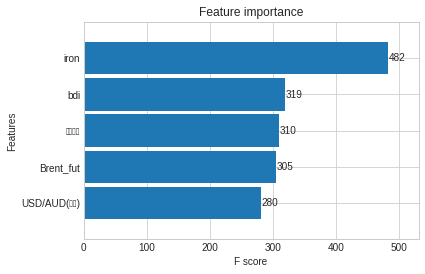

In [10]:
XG_model_month = xgb.XGBRegressor(n_estimators=1000)
XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)

# 주요하게 적용하는 변수를 판단
plot_importance(XG_model_month, height=0.9)

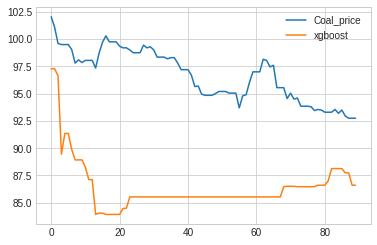

In [11]:
# 테스트 데이터 중 특정 store/item 데이터를 추출


xgboost = XG_model_month.predict(df_predict_x)

# 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
# result = result.set_index('date')
result = result.loc[:, ['Coal_price', 'xgboost']]
result.plot()

#4.Evaluation

In [ ]:
y_pred = y_tt['y_pred'].values
y_true = df_test_orig['Coal_price'].values
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

NameError: ignored

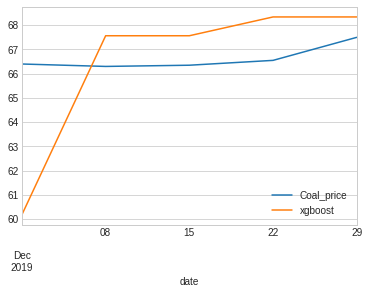